Yeah, this is totally obsolete now. K-means for the RNN isn't useful anymore.

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
from PIL import Image
from skimage.measure import block_reduce
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from kural_core.models import *
from kural_core.data_processing import *
import time
PATH = r'D:\Code\kural_work\movie_generation\data\\'

In [4]:
def k_means_classifier(img,K=3):
    img_data = img.flatten()
    cent = np.asarray([np.min(img_data),np.median(img_data),np.max(img_data)])
    for _ in range(15):
        nearest_cent = np.argmin(np.abs(img_data.reshape(-1,1)-cent.reshape(1,-1)),axis=1)
        for i in range(K):
            cent[i] = np.mean(img_data[nearest_cent==i])
    nearest_cent = np.argmin(np.abs(img_data.reshape(-1,1)-cent.reshape(1,-1)),axis=1)
    return np.uint8(nearest_cent.reshape(*img.shape))

In [2]:
files = os.listdir(PATH)

crop_width = 128
num_angles = 11
edge_param = 0.7
img = []
center_list = []
radius_list = []
mean_img_list = []
tmp_crop_list = []
min_max_list = []
counter = 0
for file in files:
#     if counter>0: break
    if file[-4:] != '.tif': continue
    print(file)
    img_ = Image.open(PATH + file)
    nf = img_.n_frames
    h = img_.height
    w = img_.width
    tmp_img = np.zeros((nf,h,w),dtype=np.float)
    for f in range(nf):
        img_.seek(f)
        tmp_img[f,:,:] = np.asarray(list(img_.getdata())).reshape(h,w)
    min_max_list.append((np.min(tmp_img), np.max(tmp_img)))
    mean_img = np.mean(tmp_img,axis=0)
    mean_img_list.append(mean_img)
    img_mask = (mean_img>(np.mean(mean_img)+np.std(mean_img))).astype(float)
    cy = sum(img_mask.T @ np.arange(h))/np.sum(img_mask)
    cx = sum(img_mask   @ np.arange(w))/np.sum(img_mask)
    center = (cy, cx)
    center_list.append(center)
    tmp = np.nonzero(img_mask)
    cell_height, cell_width = (max(tmp[i]) - min(tmp[i]) for i in range(2))
    cell_radius = np.mean([cell_height,cell_width])/2
    radius_list.append(cell_radius)
    r = cell_radius - edge_param*crop_width/2
    crop_cent = [(np.int(center[0]),np.int(center[1]))]
    for i in range(num_angles):
        crop_cent.append((np.int(center[0]+r*np.sin(2*np.pi*i/num_angles)), 
                          np.int(center[1]+r*np.cos(2*np.pi*i/num_angles))))
    tmp_img = k_means_classifier(tmp_img)
    for t, l in crop_cent:
        for f in range(nf):
            tmp_crop = tmp_img[f,t-crop_width//2:t+crop_width//2,l-crop_width//2:l+crop_width//2]
            img.append(block_reduce(tmp_crop, (4,4), np.max))
    tmp_crop_list.append(tmp_crop)
    counter+=1
print('Done')

In [95]:
with open(PATH + 'k_means_img_data.pickle', 'wb') as f:
    pickle.dump(img, f)

In [2]:
with open(PATH + 'k_means_img_data.pickle', 'rb') as f:
    img = pickle.load(f)

In [3]:
with open(PATH + 'frame_list.pickle', 'rb') as f:
    frame_list = pickle.load(f)

In [115]:
rnn_length=3
ds = kMeansImageRNNDataset(img,frame_list,num_angles=11,rnn_length=rnn_length+1)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, K=5, rand_seed=42, nORp=100)
bs = 50
train_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
val_dl = torch.utils.data.DataLoader(ds,batch_size=2*bs, sampler=SubsetSampler(val_idx))
model = kMeansModel().cuda()
opt = optim.Adam([{'params':model.inter_relate.parameters(), 'lr':5e-1},
                  {'params':model.hidden.parameters(),       'lr':1e-2},
                  {'params':model.evolve.parameters(),       'lr':1e-3}])
train_loss = []
val_loss = []
criterion = nn.MSELoss()
model.inter_relate[1].weight.data = torch.eye(1024).cuda()
model.hidden[0].weight.data = torch.eye(1024).cuda()

In [119]:
# @do_profile(follow=[AllImageRNNDataset,RandomIndicesForKFoldValidation,SubsetSampler,NFrameModel])
# def profile_fit():
restarts = 1
lr_start = 1e-3
lr_end = 1e-6
for restart in range(restarts):
    cycles = 1
    epochs = 50
    print(f'restart number {restart+1} out of {restarts}')
#     if len(train_loss)>0: opt = optim.SGD(model.parameters(), lr=lr_start, momentum=0.9)
    # lr_div = (lr_start/lr_end)**(1/epochs)
    time_list = []
    epoch_time_list = None
#     epoch_print_str = ''
    cycle_print_str = 'Cycle: 0 ~ Remaining total: Unknown'
    print(cycle_print_str,end='')
    for cycle in range(cycles):
        ts = time.clock()
#         if cycle>0: epochs = epochs*2
        lr_start = lr_start*(0.999)**cycle
        epoch_print_str = f' ~ Epoch: 0 ~ Remaining in cycle: {(epochs*np.mean(epoch_time_list) if epoch_time_list is not None else 0):.3g}s'
        print(epoch_print_str, end='')
        epoch_time_list = []
        for epoch in range(epochs):
            ets = time.clock()
#             opt.param_groups[0]['lr'] = lr_end + 0.5*(lr_start-lr_end)*(1+math.cos(epoch/epochs*np.pi))
    #         lr /= lr_div
            running_loss = 0.0
            model.train()
            for data in train_dl:
                data = data.float().cuda()
#                 data /= SCALE_FACTOR
                y_actual = data[:,rnn_length:,:,:]
                opt.zero_grad()
                x_pred = data[:,0:rnn_length,:,:]
                y_pred = model(x_pred)
                loss = criterion(y_pred,y_actual)
                loss.backward()
                opt.step()
                running_loss += loss.item()
            train_loss.append(running_loss/len(train_dl))

            running_loss = 0.0
            model.eval()
            with torch.no_grad():
                for data in val_dl:
                    data = data.float().cuda()
#                     data /= SCALE_FACTOR
                    y_actual = data[:,rnn_length:,:,:]
                    x_pred = data[:,0:rnn_length,:,:]
                    y_pred = model(x_pred)
                    running_loss += criterion(y_pred,y_actual).item()
            val_loss.append(running_loss/len(val_dl))
            epoch_time_list.append(time.clock()-ets)
            if epoch_print_str: 
                for _ in range(len(epoch_print_str)):
                    print('\b',end='')
            epoch_print_str = f' ~ Epoch: {epoch+1:2d}/{epochs} ~ Remaining in cycle: {(epochs-(epoch+1))*np.mean(epoch_time_list):.3g}s'
            print(epoch_print_str,end='')
        time_list.append(time.clock()-ts)
        if cycle_print_str: 
            for _ in range(len(cycle_print_str)+len(epoch_print_str)):
                print('\b',end='')
        remaining_time = (cycles-(cycle+1))*np.mean(time_list)
        cycle_print_str = f'Cycle: {cycle+1:3d}/{cycles} ~ Remaining total: {int(remaining_time//60)}m {remaining_time%60:02.0f}s'
        print(cycle_print_str,end='')
    for _ in range(len(cycle_print_str)):
                print('\b',end='')
    print(f'Spent {int(sum(time_list)//60)}m {sum(time_list)%60:2.0f}s doing {cycles*epochs} total steps for an average of {sum(time_list)/cycles/epochs:3.1f}s per step.')

# torch.save(model.state_dict(),'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\big_linear_rnn_model.pth')

restart number 1 out of 1
Spent 0m 18s doing 50 total steps for an average of 0.4s per step.


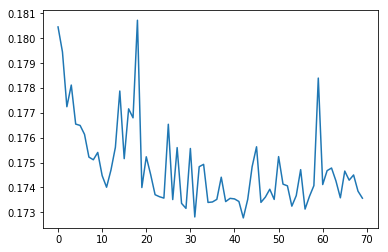

In [120]:
slc = slice(30,len(train_loss))
plt.plot(train_loss[slc])
# plt.plot(val_loss[slc])
plt.show()

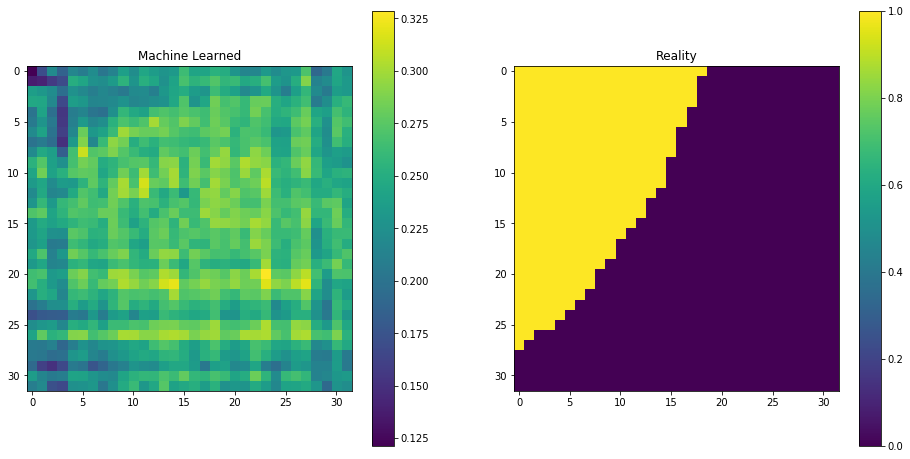

In [102]:
which_idx = train_idx
idx = np.random.choice(range(len(which_idx)))
x = ds[which_idx[idx]].cuda()
model.eval()
y_actual = x[rnn_length,:,:].cpu().data.numpy()
y_pred = model(x[0:rnn_length].float().view(1,3,32,32)).cpu().data[0].numpy()
# y_pred = np.argmax(y_pred,axis=0)
fig, ax = plt.subplots(1,2,figsize=(16,8))
im0 = ax[0].imshow(y_pred[0])
ax[0].set_title('Machine Learned')
im1 = ax[1].imshow(y_actual)
ax[1].set_title('Reality')
plt.colorbar(mappable=im0,ax=ax[0])
plt.colorbar(mappable=im1,ax=ax[1])
# lss = criterion(y_pred,x[0,rnn_length,:])
# plt.suptitle(f'loss = {lss}')
plt.show()

In [265]:
x[0:rnn_length].float().view(1,3,32,32).shape

torch.Size([1, 3, 32, 32])

In [263]:
x.shape

torch.Size([4, 32, 32])

In [271]:
torch.all(x[0:rnn_length].float().view(1,3,1024)==model.inter_relate(x[0:rnn_length].float().view(1,3,1024)))

tensor(1, device='cuda:0', dtype=torch.uint8)

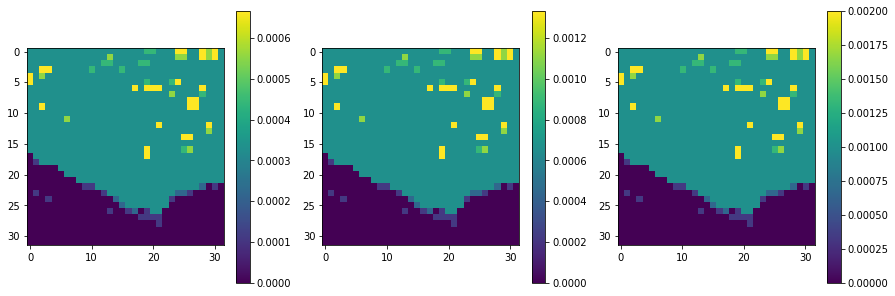

In [280]:
which_idx = train_idx
idx = np.random.choice(range(len(which_idx)))
x = ds[which_idx[idx]].cuda()
model.eval()
y_actual = x[rnn_length,:,:].view(1,32,32).cpu().data.numpy()
y_pred = model(x[0:rnn_length].float().view(1,3,32,32)).cpu().data[0].numpy()
fig, ax = plt.subplots(1,3,figsize=(15,5))
im = []
for i in range(3):
    tmp = ax[i].imshow(y_pred[i])
    im.append(tmp)
for i in range(3):
    plt.colorbar(mappable=im[i],ax=ax[i])
plt.show()

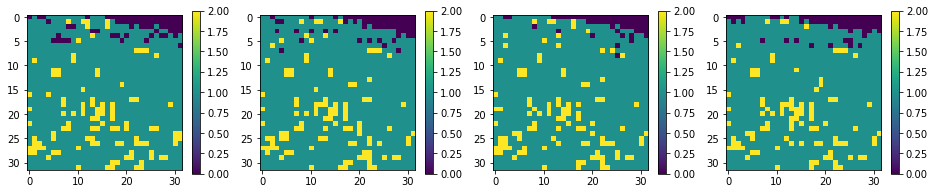

In [104]:
which_idx = train_idx
idx = np.random.choice(range(len(which_idx)))
x = ds[which_idx[idx]].cuda()
fig, ax = plt.subplots(1,4,figsize=(16,3))
im = []
for i in range(4):
    y_actual = x[i,:,:].cpu().data.numpy()
    tmp = ax[i].imshow(y_actual)
    im.append(tmp)
for i in range(4):
    plt.colorbar(mappable=im[i],ax=ax[i])
plt.show()

In [28]:
y_pred.shape

(3, 32, 32)